# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, isnull, col, rand

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Capstone Project').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.createOrReplaceTempView("spark_table")
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [4]:
print((df.count(), len(df.columns)))

(286500, 18)


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# check if any of the fields have nulls
null_list = df.toPandas().isnull().sum()
null_list

artist           58392
auth                 0
firstName         8346
gender            8346
itemInSession        0
lastName          8346
length           58392
level                0
location          8346
method               0
page                 0
registration      8346
sessionId            0
song             58392
status               0
ts                   0
userAgent         8346
userId               0
dtype: int64

Looks like there are a number of fields which has nulls. I will check on the percantage of these nulls in each of these fields and remove those which has more than 5% of nulls. 

In [7]:
# List fields having more than 5% nulls
null_pct = null_list / df.count() * 100
null_pct.loc[null_pct > 5]

artist    20.381152
length    20.381152
song      20.381152
dtype: float64

In [8]:
# remove the fields artist, length & song
df = df.drop(*['artist', 'length', 'song'])
df.show()

+---------+---------+------+-------------+--------+-----+--------------------+------+---------------+-------------+---------+------+-------------+--------------------+------+
|     auth|firstName|gender|itemInSession|lastName|level|            location|method|           page| registration|sessionId|status|           ts|           userAgent|userId|
+---------+---------+------+-------------+--------+-----+--------------------+------+---------------+-------------+---------+------+-------------+--------------------+------+
|Logged In|    Colin|     M|           50| Freeman| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Logged In|    Micah|     M|           79|    Long| free|Boston-Cambridge-...|   PUT|       NextSong|1538331630000|        8|   200|1538352180000|"Mozilla/5.0 (Win...|     9|
|Logged In|    Colin|     M|           51| Freeman| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|

In [9]:
#refresh the view
df.createOrReplaceTempView("spark_table")

In [10]:
# Check for missing values in userId
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



It looks like there are missing values in userId. Lets check the count of missing values and remove these records from the data set.

In [11]:
spark.sql("Select count(1) from spark_table where userId = ''").show()

+--------+
|count(1)|
+--------+
|    8346|
+--------+



In [12]:
# Remove these 8,346 records from the data set
df = df.filter(df['userId']!='')

In [13]:
# check to confirm is there are any more missing values in user id
df.createOrReplaceTempView("spark_table")
spark.sql("Select count(1) from spark_table where (userId = '' or userId is null)").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



In [14]:
# Check for distinct users in the data set
spark.sql("select count(distinct userId) as Distinct_User_Count from spark_table").show()

+-------------------+
|Distinct_User_Count|
+-------------------+
|                225|
+-------------------+



In [15]:
# check the cleaned data set
df.show(1)

+---------+---------+------+-------------+--------+-----+---------------+------+--------+-------------+---------+------+-------------+--------------------+------+
|     auth|firstName|gender|itemInSession|lastName|level|       location|method|    page| registration|sessionId|status|           ts|           userAgent|userId|
+---------+---------+------+-------------+--------+-----+---------------+------+--------+-------------+---------+------+-------------+--------------------+------+
|Logged In|    Colin|     M|           50| Freeman| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+---------+---------+------+-------------+--------+-----+---------------+------+--------+-------------+---------+------+-------------+--------------------+------+
only showing top 1 row



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
#Create a view to perform SQL operations
df.createOrReplaceTempView("spark_table_clean")

In [17]:
# check on the unique events performed by a user
spark.sql("Select page from spark_table_clean group by page").show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



There are total of 19 distinct events. Lets look at how each / majority of these play a role if any in determining whether a user cancels his membership / not.

In [18]:
# check number of distinct users in this data set
user_count = spark.sql("Select count(distinct userId) as Num_of_users from spark_table")
user_count.show()

+------------+
|Num_of_users|
+------------+
|         225|
+------------+



In [19]:
# get list of users who have cancelled 
cancel_user_list = spark.sql("select distinct userId from spark_table \
                        where page = 'Cancellation Confirmation'")
cancel_user_list.count()

52

In [20]:
# get list of users who have stayed with sparkify
stayed_user_list = spark.sql("select distinct userId from spark_table \
                        where userId not in (Select distinct userId from \
                        spark_table where page = 'Cancellation Confirmation')")
stayed_user_list.count()

173

In [21]:
# create views for stayed and cancelled user list
cancel_user_list.createOrReplaceTempView('cancel_list')
stayed_user_list.createOrReplaceTempView('stayed_list')

In [22]:
# 'gender' values for Stayed and cancelled users
gender_count_cancel = spark.sql("Select gender,count(distinct main.userId) as Count from spark_table_clean \
                        main inner join cancel_list cl on main.userId = cl.userId group by main.gender")

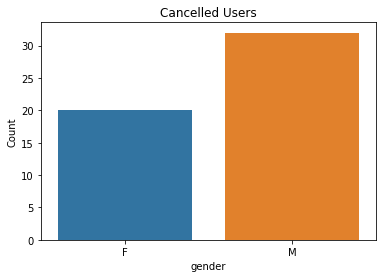

In [23]:
plt.title('Cancelled Users')
sns.barplot(x='gender',y='Count',data=gender_count_cancel.toPandas());

In [24]:
# 'gender' values for Stayed and cancelled users
gender_count_stayed = spark.sql("Select gender,count(distinct main.userId) as Count from spark_table_clean \
                        main inner join stayed_list st on main.userId = st.userId group by main.gender")

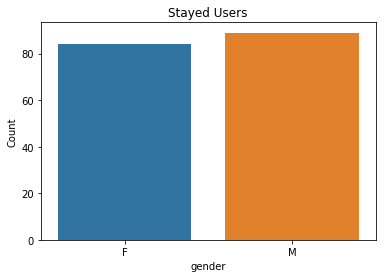

In [25]:
plt.title('Stayed Users')
sns.barplot(x='gender',y='Count',data=gender_count_stayed.toPandas());

From the charts above, it looks like Male users have more cancellation compared to females. This could be attributed to the fact that the there are more male users compared to female users. Lets check the other fields in the data set.

In [26]:
# view how the field 'level' is distributed for stayed and cancelled users
level_count_cancel = spark.sql("Select level,count(distinct main.userId) as Count from spark_table_clean \
                        main inner join cancel_list cl on main.userId = cl.userId and page = 'Cancellation Confirmation' \
                        group by main.level")

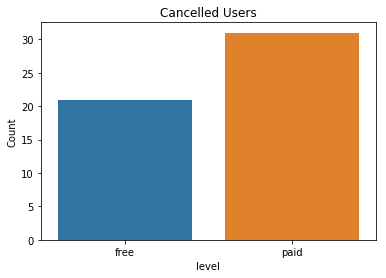

In [27]:
plt.title('Cancelled Users')
sns.barplot(x='level',y='Count',data=level_count_cancel.toPandas());

In [28]:
level_count_stayed = spark.sql("Select level,count(distinct main.userId) as Count from spark_table_clean \
                        main inner join stayed_list st on main.userId = st.userId \
                        inner join (Select userId,max(ts) max_ts from spark_table_clean group by userId) usr \
                        on main.userId = usr.userId and main.ts = usr.max_ts group by main.level")

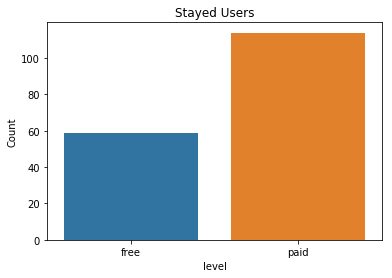

In [29]:
plt.title('Stayed Users')
sns.barplot(x='level',y='Count',data=level_count_stayed.toPandas());

From the Cancelled users chart, its obvious that paid users have more cancellations, but when you look at stayed users chart, again users who have stayed are those with paid subscription.

In [30]:
# Pages visisted by users who stayed vs who cancelled
page_count_cancel = spark.sql("Select page,count(1) as Count from spark_table_clean \
                        main inner join cancel_list cl on main.userId = cl.userId group by main.page")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

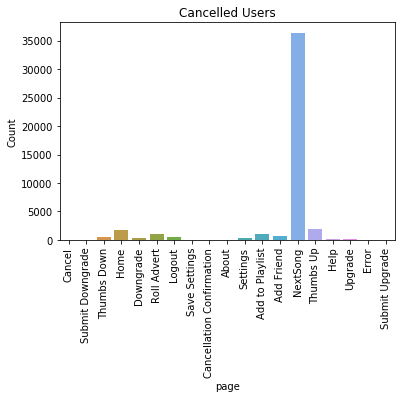

In [31]:
sns.barplot(x='page',y='Count',data=page_count_cancel.toPandas()).set_title("Cancelled Users");
plt.xticks(rotation = 90)

In [32]:
page_count_cancel.show(truncate=False)

+-------------------------+-----+
|page                     |Count|
+-------------------------+-----+
|Cancel                   |52   |
|Submit Downgrade         |9    |
|Thumbs Down              |496  |
|Home                     |1672 |
|Downgrade                |337  |
|Roll Advert              |967  |
|Logout                   |553  |
|Save Settings            |58   |
|Cancellation Confirmation|52   |
|About                    |56   |
|Settings                 |270  |
|Add to Playlist          |1038 |
|Add Friend               |636  |
|NextSong                 |36394|
|Thumbs Up                |1859 |
|Help                     |239  |
|Upgrade                  |112  |
|Error                    |32   |
|Submit Upgrade           |32   |
+-------------------------+-----+



In [33]:
page_count_stayed = spark.sql("Select page,count(1) as Count from spark_table_clean \
                        main inner join stayed_list st on main.userId = st.userId group by main.page")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

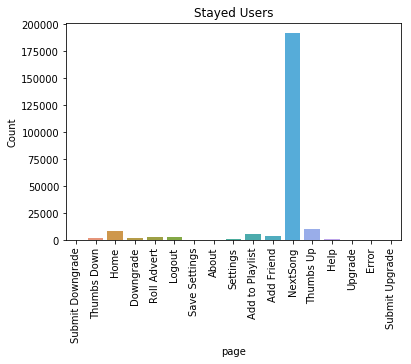

In [34]:
sns.barplot(x='page',y='Count',data=page_count_stayed.toPandas()).set_title("Stayed Users");
plt.xticks(rotation = 90)

In [35]:
page_count_stayed.show(truncate=False)

+----------------+------+
|page            |Count |
+----------------+------+
|Submit Downgrade|54    |
|Thumbs Down     |2050  |
|Home            |8410  |
|Downgrade       |1718  |
|Roll Advert     |2966  |
|Logout          |2673  |
|Save Settings   |252   |
|About           |439   |
|Settings        |1244  |
|Add to Playlist |5488  |
|Add Friend      |3641  |
|NextSong        |191714|
|Thumbs Up       |10692 |
|Help            |1215  |
|Upgrade         |387   |
|Error           |220   |
|Submit Upgrade  |127   |
+----------------+------+



From the chart and the data above, it looks like Users who have cancelled and stayed , both visited NextSong and Home page more often than others suggesting they were looking to explore more songs. Also events like Downgrade, Thumbs Down can be related to users who are not happy and events like Add Friend, Upgrade can be linked to users who prefer to stay.

In [36]:
# Explore on the Date and Time aspect of the users
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). strftime("%H"))
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). strftime("%d"))
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). strftime("%A"))


In [37]:
df = df.withColumn("hour", get_hour(df.ts)) \
        .withColumn("day", get_day(df.ts)) \
        .withColumn("weekday", get_weekday(df.ts)) \
        .drop("ts")

In [38]:
# Replace view
df.createOrReplaceTempView("spark_table_clean")

In [39]:
# number of users active by the hour of the day
users_cancel_by_hour = spark.sql("Select hour,count(1) as Count from spark_table_clean \
                        main inner join cancel_list cl on main.userId = cl.userId group by main.hour")

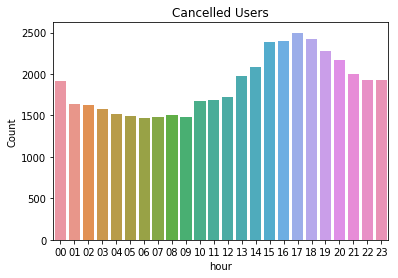

In [40]:
sns.barplot(x='hour',y='Count',data=users_cancel_by_hour.toPandas()).set_title('Cancelled Users');

In [41]:
users_stayed_by_hour = spark.sql("Select hour,count(1) as Count from spark_table_clean \
                        main inner join stayed_list st on main.userId = st.userId group by main.hour")

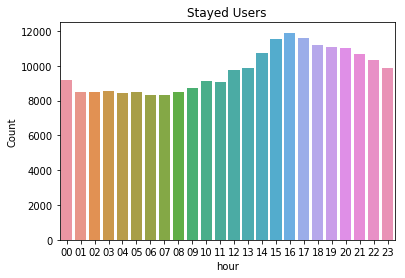

In [42]:
sns.barplot(x='hour',y='Count',data=users_stayed_by_hour.toPandas()).set_title('Stayed Users');

Users who have stayed seem to have very consistent interaction through out the duration of the day whereas interactions of users who have cancelled seem to be have a dip in the morning as compared to afternoon / evening.

In [43]:
# Users Behaviour by days of the month
users_cancel_by_days = spark.sql("Select day,count(1) as Count from spark_table_clean \
                        main inner join cancel_list cl on main.userId = cl.userId group by main.day")

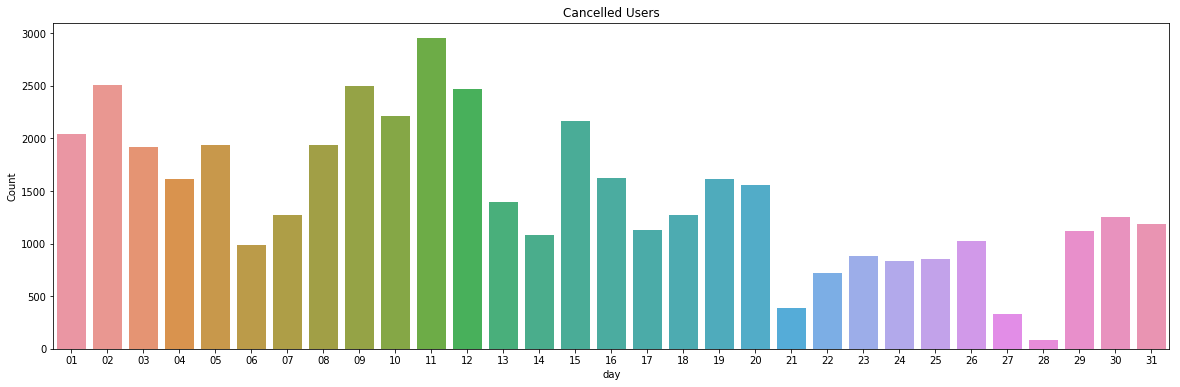

In [44]:
plt.figure(figsize=(20,6))
sns.barplot(x="day",y="Count", data=users_cancel_by_days.toPandas()).set_title('Cancelled Users');

In [45]:
users_stayed_by_days = spark.sql("Select day,count(1) as Count from spark_table_clean \
                        main inner join stayed_list st on main.userId = st.userId group by main.day")

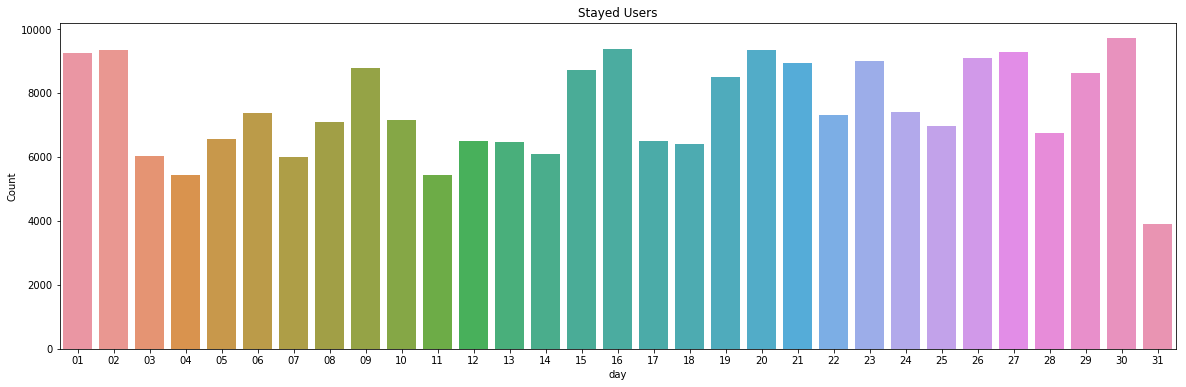

In [46]:
plt.figure(figsize=(20,6))
sns.barplot(x="day",y="Count", data=users_stayed_by_days.toPandas()).set_title('Stayed Users');

Users who have stayed seem to have a fairly consistent interaction throughout the month, but the interaction of users who have cancelled seems to decrease in the second half of the month.

In [47]:
# User behaviour by weekdays
users_cancel_by_weekday = spark.sql("Select weekday,count(1) as Count from spark_table_clean \
                        main inner join cancel_list cl on main.userId = cl.userId group by main.weekday")

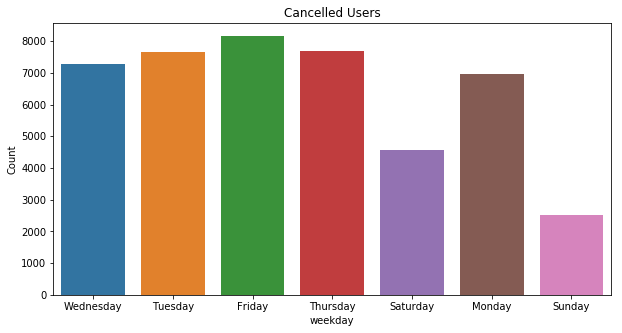

In [48]:
plt.figure(figsize=(10,5))
sns.barplot( x="weekday",y="Count", data=users_cancel_by_weekday.toPandas()).set_title('Cancelled Users');

In [49]:
users_stayed_by_weekday = spark.sql("Select weekday,count(1) as Count from spark_table_clean \
                        main inner join stayed_list st on main.userId = st.userId group by main.weekday")

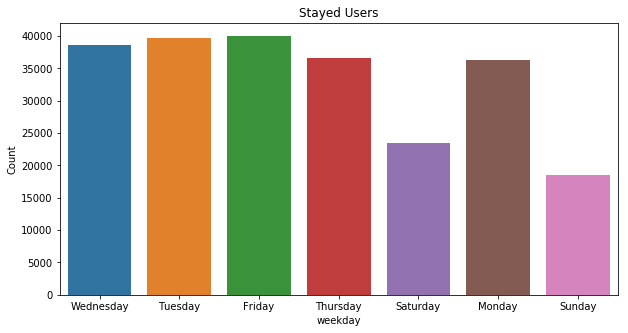

In [50]:
plt.figure(figsize=(10,5))
sns.barplot( x="weekday",y="Count", data=users_stayed_by_weekday.toPandas()).set_title('Stayed Users');

Users interaction with the system seem to be consistent for both who have stayed as well as who have cancelled their service.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [51]:
df.printSchema()

root
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- weekday: string (nullable = true)



In [52]:
# remove attributes that will not be used
df = df.drop(*['auth','firstName','gender','itemInSession','lastName', \
              'location','method','registration','sessionId','status', \
              'userAgent'])

In [53]:
df.show()

+-----+---------------+------+----+---+-------+
|level|           page|userId|hour|day|weekday|
+-----+---------------+------+----+---+-------+
| paid|       NextSong|    30|  00| 01| Monday|
| free|       NextSong|     9|  00| 01| Monday|
| paid|       NextSong|    30|  00| 01| Monday|
| free|       NextSong|     9|  00| 01| Monday|
| paid|       NextSong|    30|  00| 01| Monday|
| free|       NextSong|     9|  00| 01| Monday|
| free|       NextSong|     9|  00| 01| Monday|
| paid|       NextSong|    30|  00| 01| Monday|
| paid|Add to Playlist|    30|  00| 01| Monday|
| paid|       NextSong|    30|  00| 01| Monday|
| free|       NextSong|     9|  00| 01| Monday|
| free|    Roll Advert|     9|  00| 01| Monday|
| paid|       NextSong|    30|  00| 01| Monday|
| free|       NextSong|     9|  00| 01| Monday|
| free|      Thumbs Up|     9|  00| 01| Monday|
| paid|       NextSong|    30|  00| 01| Monday|
| free|       NextSong|     9|  00| 01| Monday|
| free|       NextSong|    74|  00| 01| 

In [54]:
df.createOrReplaceTempView('spark_table_feat')

In [55]:
# Define feature (Categorical) based on Level (Paid Vs Free)
df_feature = spark.sql("Select main.userId, freelvl.freelevel, paidlvl.paidlevel from \
            (select distinct userId from spark_table_feat) main left outer join \
            (Select userId, level as freelevel from spark_table_feat \
            where level = 'free' group by userId, level) freelvl on \
            main.userId = freelvl.userId Left outer join \
            (Select userId, level as paidlevel from spark_table_feat \
            where level = 'paid' group by userId, level) paidlvl \
            on main.userId = paidlvl.userId")

Define few Numerical Features

In [56]:
# calculate frequency of user visits by AM/PM of the day
hourfList = []
hour_split = spark.sql("select userId,sum(case when hour between '00' and '11' Then 1 Else 0 End) as Day_AM_Count \
        ,sum(case when hour between '12' and '23' Then 1 Else 0 End) as Day_PM_Count \
        from spark_table_feat group by userId")

for c in hour_split.columns[1:]:
    hour_dtl = hour_split.select(["userId",c])
    hourfList.append(hour_dtl)

In [57]:
# calculate frequency of user visits by First half / second half of month
monthfList = []
month_split = spark.sql("select userId,sum(case when day between '01' and '15' Then 1 Else 0 End) as FH_Mth_Count \
        ,sum(case when day > '15' Then 1 Else 0 End) as SH_Mth_Count \
        from spark_table_feat group by userId")

for c in month_split.columns[1:]:
    month_dtl = month_split.select(["userId",c])
    monthfList.append(month_dtl)

In [58]:
# Calculate number of visits to each page by user
# Restrict the events only to important page events
df_page = spark.sql("Select userId, page, count(*) as Count from spark_table_feat \
            where page in ('Submit Downgrade','Thumbs Down','Cancellation Confirmation', \
            'Downgrade', 'Add Friend', 'Thumbs Up', 'NextSong','Upgrade', 'Submit Upgrade') group by userId, page")

df_page_list = df_page.groupby("userId").pivot("page").sum("Count")
page_split = df_page_list.select([col(c).alias(c.replace(' ', '_')) for c in df_page_list.columns])

In [59]:
pagefList = []
for c in page_split.columns[1:]:
    each_page = page_split.select(["userId",c])
    pagefList.append(each_page)

In [60]:
# consolidate the numerical features
numfeaturesList = []
for f in [hourfList, monthfList, pagefList]:
    numfeaturesList.extend(f)

In [61]:
numfeaturesList

[DataFrame[userId: string, Day_AM_Count: bigint],
 DataFrame[userId: string, Day_PM_Count: bigint],
 DataFrame[userId: string, FH_Mth_Count: bigint],
 DataFrame[userId: string, SH_Mth_Count: bigint],
 DataFrame[userId: string, Add_Friend: bigint],
 DataFrame[userId: string, Cancellation_Confirmation: bigint],
 DataFrame[userId: string, Downgrade: bigint],
 DataFrame[userId: string, NextSong: bigint],
 DataFrame[userId: string, Submit_Downgrade: bigint],
 DataFrame[userId: string, Submit_Upgrade: bigint],
 DataFrame[userId: string, Thumbs_Down: bigint],
 DataFrame[userId: string, Thumbs_Up: bigint],
 DataFrame[userId: string, Upgrade: bigint]]

In [62]:
# Create a new dataframe with Categorical (Level) feature and numerical feature
for f in numfeaturesList:
    df_feature = df_feature.join(f, ['userId'], how='full')

In [63]:
df_feature.show()

+------+---------+---------+------------+------------+------------+------------+----------+-------------------------+---------+--------+----------------+--------------+-----------+---------+-------+
|userId|freelevel|paidlevel|Day_AM_Count|Day_PM_Count|FH_Mth_Count|SH_Mth_Count|Add_Friend|Cancellation_Confirmation|Downgrade|NextSong|Submit_Downgrade|Submit_Upgrade|Thumbs_Down|Thumbs_Up|Upgrade|
+------+---------+---------+------------+------------+------------+------------+----------+-------------------------+---------+--------+----------------+--------------+-----------+---------+-------+
|100010|     free|     null|         166|         215|         233|         148|         4|                     null|     null|     275|            null|          null|          5|       17|      2|
|200002|     free|     paid|         108|         366|         177|         297|         4|                     null|        5|     387|            null|             1|          6|       21|      2|
|   1

In [64]:
# Check if the new dataframe has any nulls
df_feature.toPandas().isnull().sum()

userId                         0
freelevel                     30
paidlevel                     60
Day_AM_Count                   0
Day_PM_Count                   0
FH_Mth_Count                   0
SH_Mth_Count                   0
Add_Friend                    19
Cancellation_Confirmation    173
Downgrade                     71
NextSong                       0
Submit_Downgrade             176
Submit_Upgrade                94
Thumbs_Down                   22
Thumbs_Up                      5
Upgrade                       57
dtype: int64

In [65]:
# Fix the null values in freelevel & paidlevel
fix_null = udf(lambda x: 1 if x else 0)
df_feature = df_feature.withColumn("freelevel", fix_null(df_feature.freelevel))
df_feature = df_feature.withColumn("paidlevel", fix_null(df_feature.paidlevel))

In [66]:
# Fill nulls with 0's on all columns
df_feature = df_feature.fillna(0)

In [67]:
# Validate if all nulls have been fixed
df_feature.toPandas().isnull().sum()

userId                       0
freelevel                    0
paidlevel                    0
Day_AM_Count                 0
Day_PM_Count                 0
FH_Mth_Count                 0
SH_Mth_Count                 0
Add_Friend                   0
Cancellation_Confirmation    0
Downgrade                    0
NextSong                     0
Submit_Downgrade             0
Submit_Upgrade               0
Thumbs_Down                  0
Thumbs_Up                    0
Upgrade                      0
dtype: int64

In [68]:
# Define Churn based on column 'Cancellation_Confirmation'
get_churn = udf(lambda x: 1 if int(x) > 0 else 0)
df_feature = df_feature.withColumn("Churn", get_churn(df_feature.Cancellation_Confirmation))

In [69]:
df_feature.printSchema()

root
 |-- userId: string (nullable = true)
 |-- freelevel: string (nullable = true)
 |-- paidlevel: string (nullable = true)
 |-- Day_AM_Count: long (nullable = true)
 |-- Day_PM_Count: long (nullable = true)
 |-- FH_Mth_Count: long (nullable = true)
 |-- SH_Mth_Count: long (nullable = true)
 |-- Add_Friend: long (nullable = true)
 |-- Cancellation_Confirmation: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Submit_Downgrade: long (nullable = true)
 |-- Submit_Upgrade: long (nullable = true)
 |-- Thumbs_Down: long (nullable = true)
 |-- Thumbs_Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- Churn: string (nullable = true)



In [70]:
# convert column (except userId) datatypes to float
for c in df_feature.columns[1:]:
    df_feature = df_feature.withColumn(c, df_feature[c].cast("float"))

In [71]:
# define features for classification
featurelist = df_feature.columns
featurelist.remove('userId')
featurelist.remove('Cancellation_Confirmation')
featurelist.remove('Churn')

In [72]:
# combine features using VecotrAssembler
assembler = VectorAssembler(inputCols=featurelist, outputCol="ChurnFeatures")
df_feature = assembler.transform(df_feature)

In [73]:
# scale features using Normalizer
scaler = Normalizer(inputCol="ChurnFeatures", outputCol="NormalizedChurnFeatures")
df_feature = scaler.transform(df_feature)

In [74]:
df_feature.select('userId', 'ChurnFeatures', 'NormalizedChurnFeatures').show()

+------+--------------------+-----------------------+
|userId|       ChurnFeatures|NormalizedChurnFeatures|
+------+--------------------+-----------------------+
|100010|[1.0,0.0,166.0,21...|   [0.00210382302738...|
|200002|[1.0,1.0,108.0,36...|   [0.00155145639183...|
|   125|(14,[0,2,4,8],[1....|   (14,[0,2,4,8],[0....|
|   124|[0.0,1.0,1974.0,2...|   [0.0,1.5688704788...|
|    51|[0.0,1.0,1177.0,1...|   [0.0,2.8273434420...|
|     7|[1.0,0.0,109.0,92...|   [0.00384030694188...|
|    15|[0.0,1.0,818.0,14...|   [0.0,3.2666022451...|
|    54|[1.0,1.0,1407.0,2...|   [2.13998472176201...|
|   155|[1.0,1.0,691.0,31...|   [7.55129579016604...|
|100014|[0.0,1.0,33.0,277...|   [0.0,0.0022321039...|
|   132|[1.0,1.0,889.0,14...|   [3.24601645480006...|
|   154|(14,[0,3,4,5,6,8,...|   (14,[0,3,4,5,6,8,...|
|   101|[1.0,1.0,1156.0,9...|   [3.22726156603460...|
|    11|[1.0,1.0,317.0,53...|   [9.21245106742600...|
|   138|[1.0,1.0,1219.0,1...|   [2.82697906462169...|
|300017|[0.0,1.0,1434.0,2...

## Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [75]:
data = df_feature.select(col("Churn").alias("label"), col("NormalizedChurnFeatures").alias("features"))

In [91]:
data.createOrReplaceTempView("data_for_Model")

In [92]:
spark.sql("Select label,count(1) as Count from data_for_Model group by label").show()

+-----+-----+
|label|Count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



The data set is not balanced. Most of the models do not work well with an imbalanced data set. Given the whole data set is relatively small, i will oversample (using sampling) the churned data to match to the stayed data set.

In [99]:
#oversample the churn
df_majority = data.where(data.label == '0')
df_minority = data.where(data.label == '1')
fraction = (data.where(data.label == '0').count()) / (data.where(data.label == '1').count())
df_minority_upsample = df_minority.sample(True,fraction,42)

In [103]:
df_balanced = df_minority_upsample.unionAll(df_majority)
df_balanced = df_balanced.orderBy(rand())
df_balanced.groupBy(df_balanced.label).count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  161|
|  0.0|  173|
+-----+-----+



In [105]:
# Split into Train and Test data set
train, test = df_balanced.randomSplit([0.9, 0.1], seed=42)

In [106]:
#function to conver row obejct to string
convert_row_to_string = lambda x, y: x.asDict()[y]

In [107]:
# Define a function to evaluate model metrics
def get_metrics(model):
    TP, FP, FN, TN = [0 for i in range(4)]
    
    label = model.select(["label"]).collect()
    prediction = model.select(["prediction"]).collect()
    labelList = list(map(convert_row_to_string, label, ['label' for i in range(len(label))]))
    predictionList = list(map(convert_row_to_string, prediction, ['prediction' for i in range(len(prediction))]))
    
    for i, (l, p) in enumerate(zip(labelList, predictionList)):    
        if (l == 1) and (p == 1):
            TP += 1
        elif (l == 0) and (p == 1):
            FP += 1
        elif (l == 1) and (p == 0):
            FN += 1
        elif (l == 0) and (p == 0):
            TN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f_score

###### Compare Different Models

In [108]:
# define evaluator to evaluate binary classification performance
evaluator = BinaryClassificationEvaluator()

###### Logistic Regression

In [109]:
lr = LogisticRegression()
prediction_lr = lr.fit(train).transform(test)
lr_result = prediction_lr.select(['prediction', 'label'])

In [110]:
accuracy, precision, recall, f_score = get_metrics(lr_result)

print("Logistic Regression Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Logistic Regression Metrics:

Accuracy = 0.756098
Precison = 0.666667
Recall = 0.666667
F1 Score = 0.666667


In [111]:
ROC = evaluator.evaluate(prediction_lr, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC is: %f" % ROC)

Area Under ROC is: 0.835897


###### Random Forest Classifier

In [112]:
rfc = RandomForestClassifier()
prediction_rfc = rfc.fit(train).transform(test)
rfc_result = prediction_rfc.select(['prediction', 'label'])

In [113]:
accuracy, precision, recall, f_score = get_metrics(rfc_result)

print("Random Forest Classifier Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Random Forest Classifier Metrics:

Accuracy = 0.878049
Precison = 0.777778
Recall = 0.933333
F1 Score = 0.848485


In [114]:
ROC = evaluator.evaluate(prediction_rfc, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC is: %f" % ROC)

Area Under ROC is: 0.961538


###### Decision Tree Classifier

In [115]:
dtc = DecisionTreeClassifier()
prediction_dtc = dtc.fit(train).transform(test)
dtc_result = prediction_dtc.select(['prediction', 'label'])

In [116]:
accuracy, precision, recall, f_score = get_metrics(dtc_result)

print("Decision Tree Classifier Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Decision Tree Classifier Metrics:

Accuracy = 0.780488
Precison = 0.666667
Recall = 0.800000
F1 Score = 0.727273


In [117]:
ROC = evaluator.evaluate(prediction_dtc, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC is: %f" % ROC)

Area Under ROC is: 0.680769


Looking at the performance metrics of the three models, it is very clear that Random Forest Classifier performs way better than Logistic regression and Decision Tree. The Random Forest model has Accuracy of 87.8% and F1-Score of 84.8%. Also the ROC of 0.96 is impressive as well. Although these values are impressive i will go ahead and play around with the parameters to see if i can further improve the performace with Random Forest Classifier. 

#### Fine Tune Random Forest Classifier for performance optimization

In [118]:
# build param grid

paramGrid = ParamGridBuilder()\
    .addGrid(rfc.numTrees,[50, 100])\
    .addGrid(rfc.maxDepth,[10, 30])\
    .build()

In [119]:
# Crossvalidation
cv = CrossValidator(estimator=rfc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

In [120]:
# Model Training
cv_model = cv.fit(train)

In [121]:
# Model Prediction
prediction = cv_model.transform(test)
results_cv = prediction.select(['prediction', 'label'])

In [122]:
accuracy, precision, recall, f_score = get_metrics(results_cv)
print("Optimized Random Forest Classifier Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Optimized Random Forest Classifier Metrics:

Accuracy = 0.951220
Precison = 0.933333
Recall = 0.933333
F1 Score = 0.933333


In [123]:
ROC = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC is: %f" % ROC)

Area Under ROC is: 0.982051


In [126]:
#finding the ideal parameters for the model
Model = cv_model.bestModel
print("Ideal value for 'numTrees' Parameter = %f" % Model.getNumTrees)
print("Ideal value for 'maxDepth' Parameter = %f" % Model.getOrDefault('maxDepth'))

Ideal value for 'numTrees' Parameter = 100.000000
Ideal value for 'maxDepth' Parameter = 30.000000


This is a great result for the model. with the parameters of numTrees = 100 and maxDepth = 30, the Random Forest Classifier acheived the near perfect metrics of accuracy = 95.12%, F1-Score of 93.3% coupled with ROC of 0.98. This is the ideal model for this problem. We should be mindfull that these results are based on the mini dataset and when we try to use it with a larger dataset the results could vary and those needs to be addressed as required. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.